# Crack detection in concrete

In [ ]:
# For colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# For colab
#!pip install split-folders
#!pip install timm

## Importing necessary libraries

In [36]:
import pandas as pd
import os
import random
import cv2
from matplotlib import pyplot as plt
import splitfolders
import numpy as np
from torchsummary import summary
from torch import nn
import copy
import time
import timm
import torch
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
import sys
from time import sleep

# Define constant variables

In [34]:
BATCH_SIZE = 8

## Loading the dataset

In [35]:
positive_dataset_path = './Concrete Crack Images for Classification/Positive/'
negative_dataset_path = './Concrete Crack Images for Classification/Negative/'
dataset_path = "Concrete Crack Images for Classification"

In [ ]:
# For colab
#positive_dataset_path = './drive/MyDrive/ML/Concrete Crack Images for Classification/Positive/'
#negative_dataset_path = './drive/MyDrive/ML/Concrete Crack Images for Classification/Negative/'
#dataset_path = "Concrete Crack Images for Classification"

In [3]:
pos_images = os.listdir(positive_dataset_path)
neg_images = os.listdir(negative_dataset_path)

### Display random positive and negative image

Number of images with cracks: 20000
Number of images without crack: 20000
Image with a crack


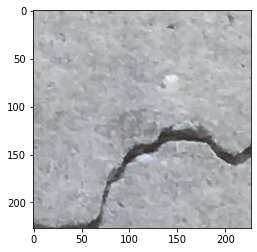

Image without a crack


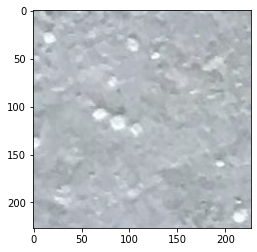

In [4]:
print('Number of images with cracks:', len(pos_images))
print('Number of images without crack:', len(neg_images))
rand_pos_path = pos_images[random.randint(0,len(pos_images))]
rand_pos_img = cv2.imread(f'{positive_dataset_path}{rand_pos_path}')
rand_neg_path = neg_images[random.randint(0,len(neg_images))]
rand_neg_img = cv2.imread(f'{negative_dataset_path}{rand_neg_path}')
print("Image with a crack")
plt.imshow(rand_pos_img)
plt.show()
print("Image without a crack")
plt.imshow(rand_neg_img)
plt.show()

### Divide into train, test and validation

In [9]:
root_dir = 'Images'
pos_dir = 'Positive'
neg_dir = 'Negative'

In [10]:
# For google colab
#root_dir = './drive/MyDrive/ML/Images/'

In [11]:
def split_data():
    splitfolders.ratio(input=dataset_path, output=root_dir, seed=1337, ratio=(.7, .15, .15), group_prefix=None )
# split_data()

In [12]:
train_pos = os.listdir(f'{root_dir}/train/{pos_dir}')
train_neg = os.listdir(f'{root_dir}/train/{neg_dir}')
val_pos = os.listdir(f'{root_dir}/val/{pos_dir}')
val_neg = os.listdir(f'{root_dir}/val/{neg_dir}')
test_pos = os.listdir(f'{root_dir}/test/{pos_dir}')
test_neg = os.listdir(f'{root_dir}/test/{neg_dir}')


In [14]:
print("Number of train positive: ", len(train_pos))
print("Number of train neg: ", len(train_neg))
print("Number of val positive: ", len(val_pos))
print("Number of val neg: ", len(val_neg))
print("Number of test positive: ", len(test_pos))
print("Number of test neg: ", len(test_neg))

Number of train positive:  14000
Number of train neg:  14000
Number of val positive:  3000
Number of val neg:  3000
Number of test positive:  3000
Number of test neg:  3000


## Dataloader and transform

#### OBS!!! Using default mean and std. Should we calculate these our selfs?

In [27]:
BATCH_SIZE = 8

In [26]:
# IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
# IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
data_transformer = {'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
]), 'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])}

In [19]:
def get_dataset(root_dir, mode):
    path = os.path.join(root_dir, mode)
    transformer = None if mode == "test" else data_transformer[mode]
    dataset = datasets.ImageFolder(
        root = path,
        transform = transformer
    )
    return dataset

In [20]:
def dataloader(root_dir, mode):
    dataset = get_dataset(root_dir, mode)
    # Can have batchsize in dataloader
    data_loader = DataLoader(
        dataset,
        batch_size = BATCH_SIZE,
        shuffle =True
    )
    return data_loader, dataset

In [21]:
dataloder_train, dataset_train = dataloader(root_dir, "train")
dataloader_val, dataset_val = dataloader(root_dir, "val")

In [52]:
print(f"Length of dataset: {len(dataset_train)}, classes in dataset: {dataset_train.classes}")
inputs, classes = next(iter(dataloder_train))
print("Shape of image:", inputs.shape)

Length of dataset: 28000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([8, 3, 227, 227])


### Function for visualizing images

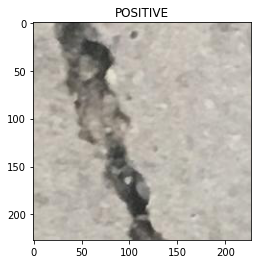

In [53]:
def show_img(img_arr, classname=None):
    img = np.transpose(img_arr.numpy(), (1, 2, 0))
    mean = np.array(IMAGENET_DEFAULT_MEAN)
    std = np.array(IMAGENET_DEFAULT_STD)
    img = img*std+mean
    plt.imshow(img)
    if classname!=None:
        title = "POSITIVE" if classname==1 else "NEGATIVE"
        plt.title(title)

# Display first image in dataloader
# Dataloader has shuffle = True, so it will be a new 
# image every time the dataloader is defined again. 
show_img(inputs[0], classes[0])

## Create basic cnn model

#### Model structure suggestion

Sequential model:
- Conv layer (activation relu)
- Max pooling
- Flatten
- Dense/Linear (softmax)
- Dropout? If overfitting

Can also repeat conv -> pooling -> conv -> pooling osv.
Can also have several Dense layer



In [37]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc_layers = nn.Sequential(
            nn.Linear(111 * 111 * 64, 128),
            nn.Linear(128, 2))
        
    def forward(self, x):
        x = self.conv_layers(x)
        # The shape of x = [8, 64, 111, 111]
        x = x.reshape(BATCH_SIZE, -1)
        x = self.fc_layers(x)
        return x

In [55]:
# defining the model
model = ConvolutionalNet()
print(model)

ConvolutionalNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=788544, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [45]:
# Define dataloaders and dataset sizes:
TRAIN_SIZE = len(dataset_train)
VAL_SIZE = len(dataset_val)

dataloaders = {'train': dataloder_train, 'val': dataloader_val}
dataset_sizes = {'train':TRAIN_SIZE, 'val':VAL_SIZE}

In [46]:
# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Defining the loss function
criterion = nn.CrossEntropyLoss()
# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [43]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [44]:
# Set model and criterion to device
model = model.to(device)
criterion = criterion.to(device)

In [48]:
#Training the model
def train(model, epochs, dataloaders, dataset_sizes, optimizer, criterion, scheduler):
    losses, accuracies  = {'train':[], 'val':[]}, {'train':[], 'val':[]}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            print(100/dataset_sizes[phase]*BATCH_SIZE*1)
            for i, data in enumerate(dataloaders[phase],0):
                inputs, classes = data
                # Print loading bar
                sys.stdout.write('\r')
                # the exact output you're looking for:
                percentage = 100/dataset_sizes[phase]*BATCH_SIZE*i
                sys.stdout.write("Epoch: %d %s:[%-20s] %.2f%%" % (epoch, phase, '='*round(percentage/10), percentage))
                sys.stdout.flush()

                # inputs, classes = inputs.to(device), classes.to(device)

                optimizer.zero_grad() # Set gradient to zero
                with torch.set_grad_enabled(phase == 'train'):
                    # Train model
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, classes)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return model, best_acc, losses, accuracies

In [49]:
model, best_acc, losses, accuracies = train(model, 2, dataloaders, dataset_sizes, optimizer, criterion, scheduler)

Starting epoch 0
0.02857142857142857
Epoch: 0 train:[                    ] 1.83%

KeyboardInterrupt: 

## Create resNet50

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.to(device)

In [ ]:
summary(resnet50, inputs[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

### Train model

In [ ]:
idx_to_class = {0:'NEGATIVE', 1: 'POSITIVE'}
TRAIN_SIZE = len(dataset_train)
VAL_SIZE = len(dataset_val)

In [ ]:
dataloaders = {'train': dataloder_train, 'val': dataloader_val}
dataset_sizes = {'train':TRAIN_SIZE, 'val':VAL_SIZE}

In [ ]:
criterion = nn.CrossEntropyLoss() # Which loss?
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def train(model, epochs, dataloaders, dataset_sizes, optimizer, criterion, scheduler):
    losses, accuracies  = {'train':[], 'val':[]}, {'train':[], 'val':[]}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            print("hello")
            print(100/dataset_sizes[phase]*BATCH_SIZE*1)
            for i, data in enumerate(dataloaders[phase],0):
                inputs, classes = data
                # Print loading bar
                sys.stdout.write('\r')
                # the exact output you're looking for:
                percentage = 100/dataset_sizes[phase]*BATCH_SIZE*i
                sys.stdout.write("Epoch: %d %s:[%-20s] %.2f%%" % (epoch, phase, '='*round(percentage/10), percentage))
                sys.stdout.flush()

                # inputs, classes = inputs.to(device), classes.to(device)

                optimizer.zero_grad() # Set gradient to zero
                with torch.set_grad_enabled(phase == 'train'):
                    # Train model
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, classes)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return model, best_acc, losses, accuracies

In [ ]:
model, best_acc, losses, accuracies = train(resnet50, 5, dataloaders, dataset_sizes, optimizer, criterion, scheduler)

Starting epoch 0
hello
0.02857142857142857
Epoch: 0 train:[==========================================================================================] 2.57%

In [ ]:
torch.save(model, 'models/resnet50_25/11_kl2300.pth')

In [ ]:
with open('models/models/resnet50_25/11_kl2300.txt', 'w') as f:
    s = f"best acc: {str(best_acc)}, losses: {str(losses)}, accuracy: {str(accuracies)}"
    f.write(s)

<class 'str'>
